# Data analysis and visualization for fairness experiments
The data parsing logic sits within utils.py

In [58]:
import os 
import json
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import re
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
pd.options.mode.chained_assignment = None  # default='warn'


# Constants
FOLDER_NAME_FAIRNESS_EXP = "../data_fairness"

# ----------------- Parsing utils ----------------
def parse_ss_output_fairness(filename):
    '''# Function to parse the ss -tni data from a text file'''
    ESTAB_REGEX = r"ESTAB 0\s+(\d+)"
    # Load data
    with open(filename, "r") as file:
        lines = file.readlines()

    # Data dictionary for storage
    data = {
        "timestamp": [],
        "cwnd": [],
        "bytes_sent": [],
        "rtt": [],
        "ssthresh" : []
    }

    i = 0
    while i < len(lines):
        # Skip to the next "---------"
        if "-----" in lines[i]:
            i += 1  # Skip this line
            if i >= len(lines):
                break
            
            # Parse timestamp
            timestamp_match = re.match(r"^Timestamp: (.+)", lines[i])
            if timestamp_match:
                timestamp = datetime.strptime(timestamp_match.group(1), "%Y-%m-%d %H:%M:%S.%f")
                i += 2  # Move to the next line to check for "ESTAB"

                if i < len(lines) and re.match(ESTAB_REGEX, lines[i]):
                    estab_match = re.match(ESTAB_REGEX, lines[i])
                    recv_q_value = int(estab_match.group(1)) if estab_match else 0
                    if recv_q_value>0:
                        i += 1  # Move to the data line
                        if i < len(lines) and ("bbr" in lines[i] or "cubic" in lines[i]):
                            line = lines[i]

                            # Extract cwnd
                            cwnd_match = re.search(r"cwnd:(\d+)", line)
                            cwnd = int(cwnd_match.group(1)) if cwnd_match else None

                            # Extract bytes_sent
                            bytes_sent_match = re.search(r"bytes_sent:(\d+)", line)
                            bytes_sent = int(bytes_sent_match.group(1)) if bytes_sent_match else None

                            # Extract RTT
                            rtt_match = re.search(r"rtt:(\d+\.\d+)", line)
                            rtt = float(rtt_match.group(1)) if rtt_match else None


                            # Extra ssthresh (if it exists!). 
                            ssthresh_match = re.search(r"ssthresh:(\d+)", line)
                            if ssthresh_match:
                                ssthresh = int(ssthresh_match.group(1))
                            else :
                                ssthresh = None

                            # Append to the data dictionary
                            data["timestamp"].append(timestamp)
                            data["cwnd"].append(cwnd)
                            data["bytes_sent"].append(bytes_sent)
                            data["rtt"].append(rtt)
                            data["ssthresh"].append(ssthresh)
                    else :
                        i+=2
                        if i < len(lines) and re.match(ESTAB_REGEX, lines[i]):
                            estab_match = re.match(ESTAB_REGEX, lines[i])
                            recv_q_value = int(estab_match.group(1)) if estab_match else 0

                            if recv_q_value > 0:
                                i += 1  # Move to the data line
                                if i < len(lines) and ("bbr" in lines[i] or "cubic" in lines[i]):
                                    line = lines[i]

                                    # Extract cwnd
                                    cwnd_match = re.search(r"cwnd:(\d+)", line)
                                    cwnd = int(cwnd_match.group(1)) if cwnd_match else None

                                    # Extract bytes_sent
                                    bytes_sent_match = re.search(r"bytes_sent:(\d+)", line)
                                    bytes_sent = int(bytes_sent_match.group(1)) if bytes_sent_match else None

                                    # Extract RTT
                                    rtt_match = re.search(r"rtt:(\d+\.\d+)", line)
                                    rtt = float(rtt_match.group(1)) if rtt_match else None



                                    # Extra ssthresh (if it exists!). 
                                    ssthresh_match = re.search(r"ssthresh:(\d+)", line)
                                    if ssthresh_match:
                                        ssthresh = int(ssthresh_match.group(1))
                                    else :
                                        ssthresh = None

                                    # Append to the data dictionary
                                    data["ssthresh"].append(ssthresh)
                                    data["timestamp"].append(timestamp)
                                    data["cwnd"].append(cwnd)
                                    data["bytes_sent"].append(bytes_sent)
                                    data["rtt"].append(rtt)
        
        i += 1  # Move to the next line

    df = pd.DataFrame(data)

    # Post-process data
    # df["timestamp"] = (df["timestamp"] - df["timestamp"].min()).dt.total_seconds()

    # bytes sent is cumulative, convert to non-cumulative
    df["bytes_sent"] = df["bytes_sent"].diff().fillna(0)


    # Convert bytes_sent to Gbps
    df["GBs_sent"] = df["bytes_sent"] * 8 / 1e9
    df["MBs_sent"] = df["bytes_sent"] / 1e6

    return df


# Example Usage
# filename = "../data_fairness/Cubic_0_BulkTraffic_u1.txt"  # Replace with your file path
# # filename = "../data/BBR_0_BulkTraffic.txt"  # Replace with your file path
# data = parse_ss_output_fairness(filename)
# print(data)

In [53]:
def get_filename_fairness(algorithm_name, loss_rate, user_nr):
    assert algorithm_name in ["BBR", "Cubic"], 'Algorithm name must be either "BBR" or "Cubic"'
    assert loss_rate in [0, 0.01, 0.005], 'Loss rate must be 0, 0.01, or 0.005'
    assert user_nr in [1,2], 'User number must be 1 or 2'
    filename =  f'{algorithm_name}_{loss_rate}_{"BulkTraffic"}_u{user_nr}.txt'
    filename = f'{FOLDER_NAME_FAIRNESS_EXP}/{filename}'
    assert os.path.exists(filename), f'File {filename} does not exist'
    return filename

KeyError: 'MBs_sent'

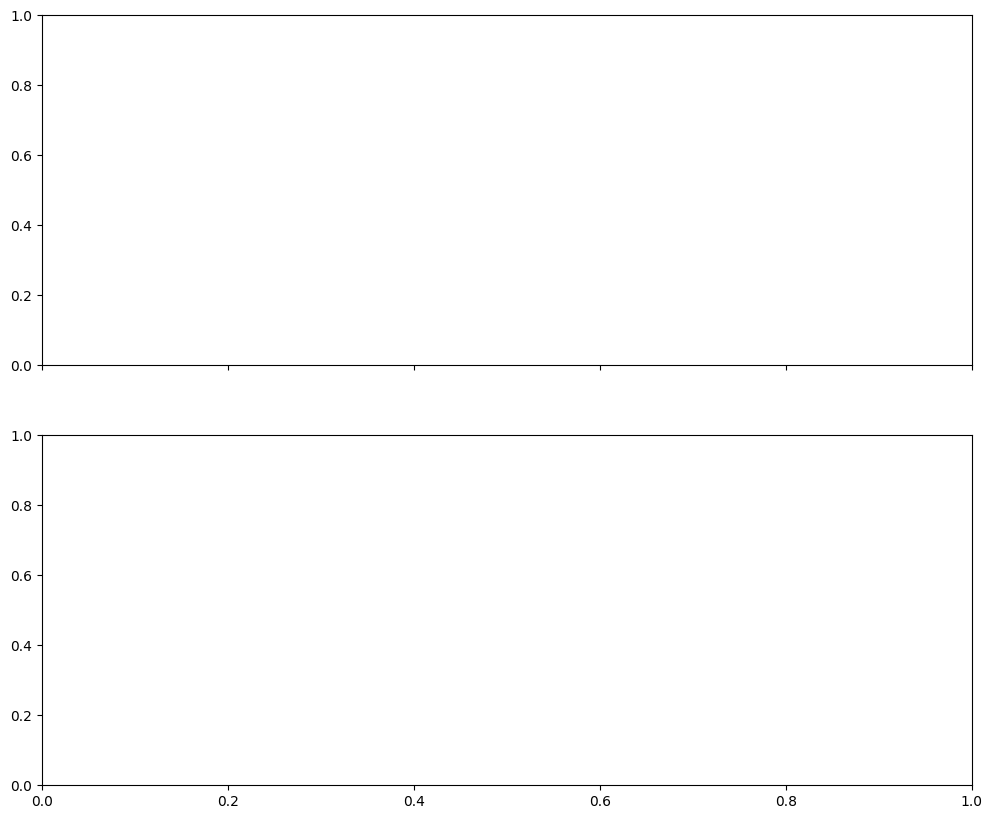

In [57]:
# Constants for font sizes
FONT_SIZE_TITLE = 16
FONT_SIZE_LABEL = 14
FONT_SIZE_TICKS = 12
FONT_SIZE_LEGEND = 12
FONT_SIZE_GRAPH_TITLE = 18

def get_and_pre_process_data_for_graphing_fairness(algorithm_name, loss_rate, connection_id, limit_x_axis_timestamp=False, smoothen_data_rate=False):
    filename = get_filename_fairness(algorithm_name, loss_rate, connection_id)
    data = parse_ss_output_fairness(filename)

    # Convert timestamps to seconds since the first timestamp
    data["timestamp"] = pd.to_datetime(data["timestamp"])
    return data

def process_and_normalize_timestamps(data1, data2):
    # Normalize time to start at 0
    start_time = min(data1["timestamp"].min(), data2["timestamp"].min())
    data1["time_seconds"] = (data1["timestamp"] - start_time).dt.total_seconds()
    data2["time_seconds"] = (data2["timestamp"] - start_time).dt.total_seconds()
    return data1, data2

def smoothen_data(data, smoothen_data_rate):
    if smoothen_data_rate:
        for col in ['MBs_sent', 'GBs_sent', 'cwnd', 'rtt', 'ssthresh']:
            data[col] = data[col].rolling(window=smoothen_data_rate).mean()
    return data

def graph_throughput_over_time_same_algorithm_two_connections(loss_rate, algorithm_name, a_axis_limit=False, smoothen_data_rate=False):
    data1 = get_and_pre_process_data_for_graphing_fairness(algorithm_name, loss_rate, 1, a_axis_limit)
    data2 = get_and_pre_process_data_for_graphing_fairness(algorithm_name, loss_rate, 2, a_axis_limit)

    data1, data2 = process_and_normalize_timestamps(data1, data2)

    if a_axis_limit:
        data1 = data1[data1["time_seconds"] < a_axis_limit]
        data2 = data2[data2["time_seconds"] < a_axis_limit]

    data1 = smoothen_data(data1, smoothen_data_rate)
    data2 = smoothen_data(data2, smoothen_data_rate)

    return data1, data2

def graph_fairness_comparison(loss_rate, a_axis_limit=False, smoothen_data_rate=False):
    fig, axs = plt.subplots(2, 1, figsize=(12, 10), sharex=True)

    for i, algorithm_name in enumerate(["BBR", "Cubic"]):
        data1, data2 = graph_throughput_over_time_same_algorithm_two_connections(loss_rate, algorithm_name, a_axis_limit, smoothen_data_rate)
        axs[i].plot(data1["time_seconds"], data1["MBs_sent"], label="User 1")
        axs[i].plot(data2["time_seconds"], data2["MBs_sent"], label="User 2")
        axs[i].set_ylabel("Throughput (Mbps)", fontsize=FONT_SIZE_LABEL)
        axs[i].set_title(f"Throughput over time for {algorithm_name} with loss rate {loss_rate}", fontsize=FONT_SIZE_TITLE)
        axs[i].tick_params(axis='both', which='major', labelsize=FONT_SIZE_TICKS)
        axs[i].legend(fontsize=FONT_SIZE_LEGEND)

    axs[1].set_xlabel("Time (s)", fontsize=FONT_SIZE_LABEL)
    
    # Set graph title
    fig.suptitle("Fairness Comparison of BBR and Cubic", fontsize=FONT_SIZE_GRAPH_TITLE, fontweight='bold')

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

# Example usage
graph_fairness_comparison(0, 80, smoothen_data_rate=5)